# Introduction
This notebook records the measures taken to reproduce the 2019 paper by Naseri et al [1] as documented by the paper *Reproducing "Analyzing and Predicting News Popularity in an Instant
Messaging Service"* by Vonderlind et al [2].

*[1]: Mohammad Naseri and Hamed Zamani. 2019. Analyzing and Predicting News Popularity in an Instant Messaging Service. In Proceedings of the 42nd International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR'19). Association for Computing Machinery, New York, NY, USA, 1053–1056. DOI:https://doi.org/10.1145/3331184.3331301*  
*[2]: Philip Vonderlind, Philipp Piwonka, and Julia Putz. 2022. Reproducing "Analyzing and Predicting News Popularity in an Instant
Messaging Service". In .Zenodo, Vienna, Austria, 6 pages. https://doi.org/10.5281/zenodo.5920074*

We will train separate models for each news agency Telegram channel, as described in the paper. Weirdly enough, the also added
the Guardian, BCC Persian and the Washington Post in their dataset, but they
are not mentioned in the paper ...

We will collect a few measures also used in the paper and investiagte the results.

As the first step, we will clone the dataset containing the Telegram data used by [Naseri 2019].

# Feature Extraction

In [40]:
# Run only if needed, e.g. when the Telegram News Folder is not yet downloaded!
#! git clone https://github.com/IceCream71/TelegramNews.git

**ISSUES FOUND**

* **Which of the .bson files are actually used for the experiment?** There
is no indication if Washington Post and BBC Persia etc. are used for the
experiments, as they are not mentioned in the paper itself.

* **How are the binary labels acutally generated from the data?** There is no indication for the threshold they used in the paper. They mention only: "Therefore, we first found the thresholds that satisfy these percent-
ages for training and test sets and assigned a binary label to each
post (“popular” or “not popular”). "

* **How are the features generated from the data (manually, algorithm, ...)?** This would be important as the bson data does **not** have the same features. List of issues: What is the n-grams thing? How do we generate the hashtags and mention features? How are we supposed to generate the media-type features? What does Has Link mean (could be either the enitity type URL or a media page containing a url tag...).

* **There is a typo in the features table** We can't really reproduce
the #mentions features without guessing that they mean the count of the mentions
in a post (They use the same text as for the hashtags)

* **How are the NaN in the data handled?** Could be removed, zero-filled, interpolated. We just don't know...

missing features (which can't be calculated due to missing information): 

* subscribers (shows the popularity of channel)
* channel age (date of first post? in days)
* frequent n-grams (frequent n-grams that news item contains)
* frequent hashtags (frequent hashtags that news item contains)
* frequent mentions (frequent mentions that news item contains)

what does frequent mean?

In [2]:
import pandas as pd
import bson
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import warnings
import csv
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

In [3]:
def create_df_for_bson(path): 
  with open (path, 'rb') as f:
    data = bson.decode_all(f.read())

  df = pd.DataFrame(data)
  df = handle_NAS(df)
  df = extract_features(df)
  df = cut_date_range(df)
  df = drop_unused_features(df)
  return df

def handle_NAS(df):
  df = df.dropna(subset=['views'],axis=0)
  return df

def extract_features(df):
  df = create_datetime_features(df)
  df = add_channel_features(df)
  df = create_entity_features(df)
  return df

def create_datetime_features(df):
  df['age'] =  df.date
  df['date'] = pd.to_datetime(df.date, unit='s')
  df['year'] = df.date.dt.year
  df['month'] = df.date.dt.month
  df['day'] = df.date.dt.day
  df['weekday'] = df.date.dt.dayofweek
  df['hour'] = df.date.dt.hour
  return df

def cut_date_range(df):
  # March 8, 2017 to October 8, 2017.
  start_date = "2017-03-08"
  end_date  = "2017-10-08"
  mask = (df.date > start_date) & (df.date <= end_date)
  return df.loc[mask]

def add_channel_features(df):
  df['minViews'] = df.views.min()
  df['maxViews'] = df.views.max()
  df['meanViews'] = df.views.mean()
  df['stdViews'] = df.views.std()
  df['hourlyAvgPosts'] = df.groupby('hour').size().mean()
  df['dailyAvgPosts'] = df.groupby(['year','month','day']).size().mean()
  return df

def create_entity_features(df):
  # Convert the entity field from bson into the actual features.
  # For each row, check if media exists, if yes set media type.
  df['hasMedia'] = df.media.notnull()
  df['mediaType'] = df.apply(lambda x: x.media['_'] if x.hasMedia else '', axis=1)
  # Check if URL exists in entities, if exists, is a link
  df['hasLink'] = df.apply(lambda x: True if type(x.entities) != float and [d for d in x.entities if d['_'] ==  'messageEntityTextUrl'] else False, axis=1)
  # Collect the mentions from the entities feature
  df['mentions'] = df.apply(lambda x: len([d for d in x.entities if d['_'] == 'messageEntityMention']) if type(x.entities) != float else 0, axis=1)
  # Same as before for the hashtags
  df['hashtags'] = df.apply(lambda x: len([d for d in x.entities if d['_'] == 'messageEntityHashtag']) if type(x.entities) != float else 0, axis=1)
  return df

def drop_unused_features(df):
  return df.drop(labels=['_id','_','flags','post','id','to_id','reply_to_msg_id',
                  'media','channel','entities','message','fwd_from','edit_date',
                  'via_bot_id','reply_markup','action', 'silent'],axis=1,errors='ignore')

 
reutersWorld = create_df_for_bson('./TelegramNews/mongo/telegram/ReutersWorld.bson')
cnnBrk = create_df_for_bson('./TelegramNews/mongo/telegram/CNNBrk.bson')
pressTV = create_df_for_bson('./TelegramNews/mongo/telegram/presstv.bson')
bbcBreaking = create_df_for_bson('./TelegramNews/mongo/telegram/bbcbreaking.bson')

I added some tests belkow to check if my calculations and mappings of the features correspond to the ones reported in the paper. The results seem
fairly accurate if we take rounding into account. 

What is weird is that
the actual size of the datasets don't match up with the repoted dataset sizes
in the paper. My guess would be that they just repoted their acutal test set
sizes and not the complete set.

Mentions per news 0.4697


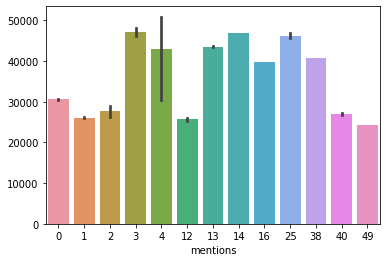

In [4]:
sns.barplot(x=cnnBrk.mentions,y=cnnBrk.index);
print(f"Mentions per news {round(cnnBrk.mentions.sum() / len(cnnBrk.index),4)}")

Hastags per news 0.0004


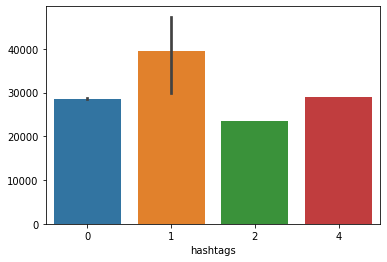

In [5]:
sns.barplot(x=cnnBrk.hashtags,y=cnnBrk.index);
print(f"Hastags per news {round(cnnBrk.hashtags.sum() / len(cnnBrk.index),4)}")

Media per news 0.5302


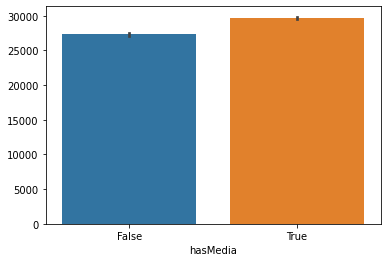

In [6]:
sns.barplot(x=cnnBrk.hasMedia,y=cnnBrk.index);
print(f"Media per news {round(len(cnnBrk[cnnBrk.hasMedia == True].index) / len(cnnBrk.index),4)}")

In [7]:
def get_statistics_for_dataset(data, label):
  news_item_count = len(data.index)
  average_views = data.views.sum() / len(data.index)
  std_views = np.std(data.views)
  avg_hastags = round(data.hashtags.sum() / len(data.index),4)
  avg_media = round(len(data[data.hasMedia == True].index) / len(data.index),4)
  avg_mentions = round(data.mentions.sum() / len(data.index),4)
  return {"NI-count": news_item_count,
          "avg_views" : average_views,
          "std_views" :std_views,
          "avg_hastags" : avg_hastags,
          "avg_media" : avg_media,
          "avg_mentions" : avg_mentions,
          "agency" : label}

In [8]:
def generate_stat_block():
  cnnStat = get_statistics_for_dataset(cnnBrk, "CNN")
  bbcStat = get_statistics_for_dataset(bbcBreaking, "BBC")
  presstvStat = get_statistics_for_dataset(pressTV , "PressTV")
  reutersStat = get_statistics_for_dataset(reutersWorld, "Reuters")
  res = pd.DataFrame([cnnStat, presstvStat, reutersStat, bbcStat])
  return res
generate_stat_block()

,NI-count,avg_views,std_views,avg_hastags,avg_media,avg_mentions,agency
0,48471,88.985827,99.930244,0.0004,0.5302,0.4697,CNN
1,7860,1183.157888,337.592685,0.0004,0.9205,0.0219,PressTV
2,11307,221.345715,94.197241,0.0001,0.1633,0.9990,Reuters
3,1838,678.303047,1930.809073,0.1436,0.9233,0.3836,BBC


# Distribution Assumptions
We can now also test the distribution assumptions for the views variable made by the authors.
For this we check all 89 distributions available in Skicit-Learn: (https://docs.scipy.org/doc/scipy/reference/stats.html)

## Issues Found

* **Which 89 distributions did they acutally test?** Scipy includes more distributions than 89 and is continually updated, so just linking to the page above is not enough ...

* **Which metric was used to evaluate goodness of fit of the dist.?** No metric is repoted in the paper.

* **Distributions do NOT MATCH with the paper !!**

In [9]:
def test_distribution(data, dist):
    print(f"Testing distribution {dist}")
    label = dist
    dist = getattr(st, dist)

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      try :
        params = dist.fit(data.views)

        #parameters of fitted distribution.
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        #calc pdf and error for fit.
        pdf = dist.pdf(np.arange(len(data.views)), loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(data.views - pdf, 2.0))

        #calc Kolgorov-Smirnov
        dist, p = st.kstest(data.views, label, args=params)
      except ValueError:
        print(f"Could not process distribution {dist}")
        return False
    return {"name" : label, "params" : params, "Error" : sse, "P-Value" : p}

In [10]:
def test_best_distribution(data):
  results = []
  # Exclude levy_stable and studentized_range as their implementations in 
  # scipy suck and take a vast amount of time to compute.
  dist_to_test = [d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]
  for dist in dist_to_test:
    res = test_distribution(data, dist)
    if res:
      results.append(res)
  return sorted(results, key=lambda x:x["P-Value"])

def generate_and_save_distribution_tests_for(data, label):
  dists = test_best_distribution(data)
  cols = ["name", "params", "Error", "P-Value"]
  with open(f'distributions/{label}.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=cols)
    writer.writeheader()
    for d in dists:
      writer.writerow(d)
  print(f"Done processing distribution tests for {label}")

In [11]:
#generate_and_save_distribution_tests_for(cnnBrk, "cnn_breaking")

In [12]:
#generate_and_save_distribution_tests_for(reutersWorld, "reuters")

In [13]:
#generate_and_save_distribution_tests_for(bbcBreaking, "bbc")

In [14]:
#generate_and_save_distribution_tests_for(pressTV, "presstv")

# Label into top 5% and top 25%

## Issues Found

* **How are the labels applied?** My guess would be via a categorical variable as target, which is also what is applied below.

* **Are there separate datasets for 25% and 5%?** I would guess this should be the case, since they mention _"Therefore, we first found the thresholds that satisfy these percent-
ages for training and test sets and assigned a binary label to each
post (“popular” or “not popular”). "_ I would say this suggest they do the experiments two times, once for each popularity prediction percentge.

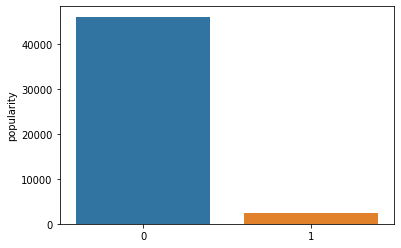

In [15]:
def produce_binary_labels(df):
  sorted = df.sort_values(by='views', ascending=False)
  top5_indices = sorted.head(int(len(df)*(5/100))).index
  top25_indices = sorted.head(int(len(df)*(25/100))).index

  # Create the target, 0 for not popular, 1 for popular
  df.loc[:,'popularity'] = 0

  top5_set = df.copy()
  top25_set = df.copy()

  top5_set.loc[top5_indices,'popularity'] = 1
  top25_set.loc[top25_indices,'popularity'] = 1

  return top5_set, top25_set

cnnBrk5, cnnBrk25 = produce_binary_labels(cnnBrk)
sns.barplot(x=[0,1], y=cnnBrk5.groupby('popularity').popularity.count());

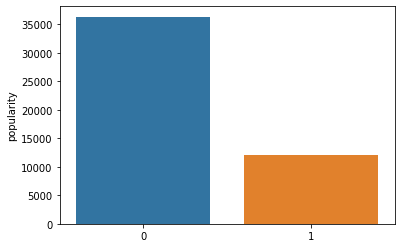

In [16]:
sns.barplot(x=[0,1], y=cnnBrk25.groupby('popularity').popularity.count());

# Split into Training/Test

## Issues Found

* **Maybe there are imbalances in train/test due to holidays or 
interesting news topics in those months?** (Just a thought)

* **Very few training samples!** The authors use 86.65% of their data for training, leaving just shy of 14% for testing. That may be an issue in case of overfitting.

* **They don't mention which columns are scaled!!** This results in static cols,
such as the std of views etc. to get put to 0!!

In [17]:
def create_train_test_split(df):
  # the first six months of the data is selected for training and the last month 
  # is selected for testing.
   # March 8, 2017 to October 8, 2017.
  train_start = "2017-03-08"
  train_end = "2017-9-08"
  mask = (df.date > train_start) & (df.date <= train_end)

  df = df.drop(labels=['date'],axis=1)
  df.mediaType = df.mediaType.astype('category').cat.codes

  training = df.loc[mask]
  test = df.loc[-mask]

  # Apply Min-Max scaling fitted on the training data
  scaler = MinMaxScaler()
  scaled_training = pd.DataFrame(scaler.fit_transform(training), columns=df.columns)
  scaled_test = pd.DataFrame(scaler.transform(test), columns=df.columns)

  return scaled_training, scaled_test

cnnTrain5, cnnTest5 = create_train_test_split(cnnBrk5)
print(f"Size of Training set: {len(cnnTrain5.index)}")
print(f"Size of Test set: {len(cnnTest5.index)}")
print(f"Percentage of train split: {round(100 * len(cnnTrain5.index) / len(cnnBrk.index),2)}%")

Size of Training set: 41998
Size of Test set: 6473
Percentage of train split: 86.65%


In [18]:
cnnTrain25, cnnTest25 = create_train_test_split(cnnBrk25)
print(f"Size of Training set: {len(cnnTrain25.index)}")
print(f"Size of Test set: {len(cnnTest25.index)}")
print(f"Percentage of train split: {round(100 * len(cnnTrain25.index) / len(cnnBrk.index),2)}%")

Size of Training set: 41998
Size of Test set: 6473
Percentage of train split: 86.65%


# SVM Partial Models (STL)

We will follow the paper and find the tuning parameter **c** by applying **5-fold CV**. We will collect the same 5 metrics mentioned in the paper. 

We also also try feature selection using randomized Lasso, as mentioned in the paper. Should their assumptions hold, the results should be that no substantial improvement can be shown.

Before training we also have to also apply the sample weighting technique mentioned for the MTL: _"Both of these models
also use a sample weighting technique, exactly the same as the one
used for MTL."_

## Issues Found

* **SVM also has other hyperparameters that they don't mention!!** These include gamma and kernel (and degree for some kernels). As they don't mention these parameters, we will just assume the default is used.

* **Not mentioned wether they do GridSearch of Randomized Search for the hyperparameter tuning!**

* **Which range of parameters for c is the search based on?** They only mention that they use 5-fold CV, but not over which range of parameters. We will just have to take some arbitrary values and hope for the best.

* **Which metric is used to decide which CV fold is the best?** E.g. which
scorer should be used to determine the optimal 'C' hyperparamter.

* **Which Kernel do they use?** Since they use linear normalization, I guess one
would use a linear kernel? This would also make the computation much faster...

In [19]:
def calculate_weights(train_df):
  n = len(train_df.index)
  labels = train_df.popularity
  popular = len(labels[labels == 1])
  not_popular = n - popular

  denominator = sum((1 / (popular if labels[k] == 1 else not_popular)) for k in range(1,n))
  bigLambda = map(lambda i: (1 / (popular if labels[i] == 1 else not_popular)) * denominator, range(0, n))
  return pd.Series(bigLambda)

bigLambdaCnn25 = calculate_weights(cnnTrain25)
bigLambdaCnn25.value_counts()

0.000063    31791
0.000196    10207
dtype: int64

In [20]:
def train_svm_wo_feature_select(train_df, weights):
  weight_array = weights.unique()
  weight_dict = {0 : weight_array[0], 1 : weight_array[1]}
  param_grid = {'C' : np.logspace(-3, 2, 6)}

  # Do 5-fold CV
  # Use LinearSVC as we get quadratic scaling for the standard RFB
  # kernel otherwise, which is unreasonable given the amount of data.
  gridSearch = GridSearchCV(LinearSVC(class_weight=weight_dict), param_grid,
                            verbose=1) 
  model = gridSearch.fit(train_df.drop('popularity', axis=1), 
                         train_df.popularity)
  print(f"Found best model :{model.best_params_}")
  return model

In [21]:
def calculate_metrics_for_model(model, test_df):
  # Get predictions from model
  test_preds = model.predict(test_df.drop('popularity', axis=1))
  test_accuracy = accuracy_score(test_df.popularity, test_preds)
  test_balanced_acc = balanced_accuracy_score(test_df.popularity, test_preds)
  test_f1 = f1_score(test_df.popularity, test_preds)
  test_precision = precision_score(test_df.popularity, test_preds)
  test_recall = recall_score(test_df.popularity, test_preds)

  print("Confusion Matrix".center(50,"-"))
  ConfusionMatrixDisplay.from_estimator(model, test_df.drop('popularity', axis=1), test_df.popularity)
  plt.show()
  
  return {"Accuracy" : test_accuracy, "Balanced_Accuracy": test_balanced_acc, 
          "Precision": test_precision, "Recall": test_recall, "F1": test_f1}


# Evaluation of model + generation for other datasets

In [22]:
def get_results_for_dataset(df, name):
  print(name.center(50,"="))

  # Create labbeled train test splits for 5% and 25%
  train, test = create_train_test_split(df)
  train5, train25 = produce_binary_labels(train)
  test5, test25 = produce_binary_labels(test)

  # Train models for 5% and 25%
  results_5 = get_model_results(train5, test5)
  results_25 = get_model_results(train25, test25)

  # Save best models to disk
  with open(f'{name}_5.pkl', 'wb') as fid:
    pickle.dump(results_5['model'], fid)  

  with open(f'{name}_25.pkl', 'wb') as fid:
    pickle.dump(results_25['model'], fid)  
  
  print(f"Results for dataset {name}:")
  print(f"5% Popularity: {results_5['metrics']}")
  print(f"25% Popularity: {results_25['metrics']}")
  return {"5" : results_5, "25" : results_25}

def get_model_results(train, test):
  train_weights = calculate_weights(train)
  model = train_svm_wo_feature_select(train, train_weights)
  metrics = calculate_metrics_for_model(model, test)
  return {"model" : model, "metrics" : metrics}

## Reuters World

=====================Reuters======================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


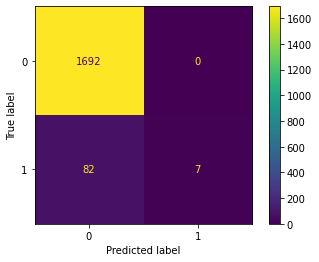

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 10.0}
-----------------Confusion Matrix-----------------


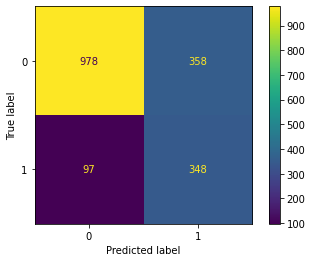

Results for dataset Reuters:
5% Popularity: {'Accuracy': 0.9539584503088153, 'Balanced_Accuracy': 0.5393258426966292, 'Precision': 1.0, 'Recall': 0.07865168539325842, 'F1': 0.14583333333333334}
25% Popularity: {'Accuracy': 0.7445255474452555, 'Balanced_Accuracy': 0.7570292000269124, 'Precision': 0.49291784702549574, 'Recall': 0.7820224719101123, 'F1': 0.6046915725456125}


In [23]:
resReuters = get_results_for_dataset(reutersWorld, "Reuters")

## CNN

=======================CNN========================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


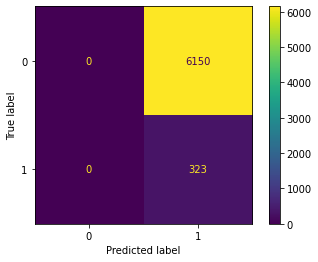

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


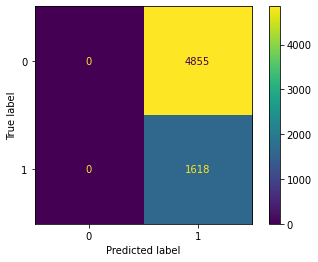

Results for dataset CNN:
5% Popularity: {'Accuracy': 0.0498995828827437, 'Balanced_Accuracy': 0.5, 'Precision': 0.0498995828827437, 'Recall': 1.0, 'F1': 0.09505591524426132}
25% Popularity: {'Accuracy': 0.2499613780318245, 'Balanced_Accuracy': 0.5, 'Precision': 0.2499613780318245, 'Recall': 1.0, 'F1': 0.399950562353232}


In [24]:
resCNN = get_results_for_dataset(cnnBrk, "CNN")

## Press TV

=====================PressTV======================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


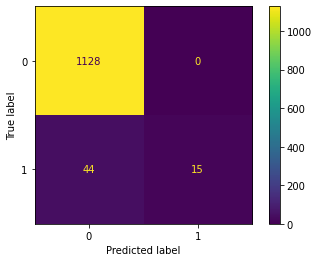

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


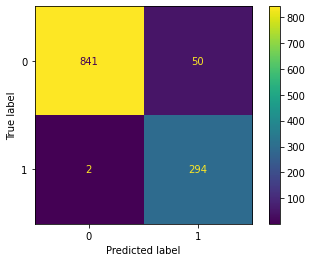

Results for dataset PressTV:
5% Popularity: {'Accuracy': 0.9629317607413648, 'Balanced_Accuracy': 0.6271186440677966, 'Precision': 1.0, 'Recall': 0.2542372881355932, 'F1': 0.4054054054054054}
25% Popularity: {'Accuracy': 0.9561920808761584, 'Balanced_Accuracy': 0.9685632602299269, 'Precision': 0.8546511627906976, 'Recall': 0.9932432432432432, 'F1': 0.91875}


In [25]:
resPressTV = get_results_for_dataset(pressTV, "PressTV")

## BBC

=======================BBC========================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 0.01}
-----------------Confusion Matrix-----------------


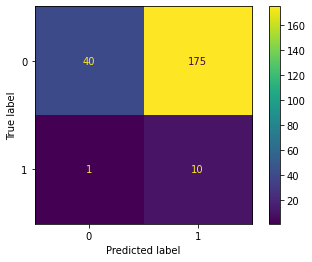

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 1.0}
-----------------Confusion Matrix-----------------


c:\users\entenzahn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


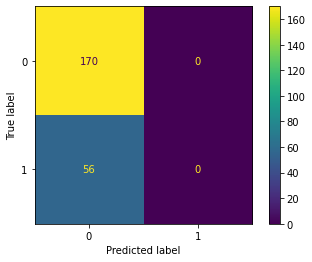

Results for dataset BBC:
5% Popularity: {'Accuracy': 0.22123893805309736, 'Balanced_Accuracy': 0.547568710359408, 'Precision': 0.05405405405405406, 'Recall': 0.9090909090909091, 'F1': 0.10204081632653063}
25% Popularity: {'Accuracy': 0.7522123893805309, 'Balanced_Accuracy': 0.5, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}


In [26]:
resBBC = get_results_for_dataset(bbcBreaking, "BBC")

## Results

The results seem similar for some of the models, but not very good for most metrics. This is probably due to inconsistencies mentioned above caused by
the authors leaving out critical information about the algorithm's hyperparamters and the pre-processing of the dataset.

From my guesses I would also say that we don't have a model that fits the
data good enough. Maybe it isn't linearily seperable. Henceforth, a simple
LinearSVC does not suffice. 

Another probable issue is the massive imbalance between training and test samples. Test sets are small to begin with, and by labelling the data using
only 5% and 25% of the data, we reduce the quantity of popular news to 
next to nothing. For this reason, most classifiers on 5% seem to just overfit
the Unpopular News (label 0) class.

# MALSAR Multitask CASO (MTL)

Next we try to reproduce the MTL performance measures by using the MALSAR package. Since we work with an external package, we need to split and evaluate the data in a slightly different order. Keep in mind the train/test split is deterministic, and therefore the datasets are comparable to the other methods.

In [27]:
cnnTrain, cnnTest = create_train_test_split(cnnBrk)
cnnTrain5, cnnTrain25 = produce_binary_labels(cnnTrain)
cnnTest5, cnnTest25 = produce_binary_labels(cnnTest)

reuTrain, reuTest = create_train_test_split(reutersWorld)
reuTrain5, reuTrain25 = produce_binary_labels(reuTrain)
reuTest5, reuTest25 = produce_binary_labels(reuTest)

bbcTrain, bbcTest = create_train_test_split(bbcBreaking)
bbcTrain5, bbcTrain25 = produce_binary_labels(bbcTrain)
bbcTest5, bbcTest25 = produce_binary_labels(bbcTest)

preTrain, preTest = create_train_test_split(pressTV)
preTrain5, preTrain25 = produce_binary_labels(preTrain)
preTest5, preTest25 = produce_binary_labels(preTest)

To prepare our data for MATLAB, we must split apart the X and Y matrices for each channel and popularity label type.

In [28]:
def split_xy(df, nm = False):
    weight = calculate_weights(df) # where to apply?
                                   
    df.loc[df.popularity == 0, "popularity"] = -1
    X = df.drop("popularity", axis=1)
    Y = df.popularity
    
    if nm:
        X.to_csv("X_"+nm+".csv", header=False, index=False)
        Y.to_csv("Y_"+nm+".csv", header=False, index=False)
        
    return X,Y

X_cnnTrain25, Y_cnnTrain25 = split_xy(cnnTrain25, 'cnn25')
X_reuTrain25, Y_reuTrain25 = split_xy(reuTrain25, 'reu25')
X_bbcTrain25, Y_bbcTrain25 = split_xy(bbcTrain25, 'bbc25')
X_preTrain25, Y_preTrain25 = split_xy(preTrain25, 'pre25')

X_cnnTest25, Y_cnnTest25 = split_xy(cnnTest25)
X_reuTest25, Y_reuTest25 = split_xy(reuTest25)
X_bbcTest25, Y_bbcTest25 = split_xy(bbcTest25)
X_preTest25, Y_preTest25 = split_xy(preTest25)

X_cnnTrain5, Y_cnnTrain5 = split_xy(cnnTrain5, 'cnn5')
X_reuTrain5, Y_reuTrain5 = split_xy(reuTrain5, 'reu5')
X_bbcTrain5, Y_bbcTrain5 = split_xy(bbcTrain5, 'bbc5')
X_preTrain5, Y_preTrain5 = split_xy(preTrain5, 'pre5')

X_cnnTest5, Y_cnnTest5 = split_xy(cnnTest5)
X_reuTest5, Y_reuTest5 = split_xy(reuTest5)
X_bbcTest5, Y_bbcTest5 = split_xy(bbcTest5)
X_preTest5, Y_preTest5 = split_xy(preTest5)

**Caution:** To proceed, the model parameters should be generated by executing edds.m. Please keep in mind the MALSAR package must be installed as laid out in the manual. For quick re-execution, the model files are already included in the repository.

Once the MATLAB module has been executed, the following code will reimport the calculated model coefficients and apply it to our train and test sets for evaluation metrics:

predicted,-1.0,1.0
original,,
-1,27966,3533
1,8618,1881


-----------CNN Train25 Confusion Matrix-----------


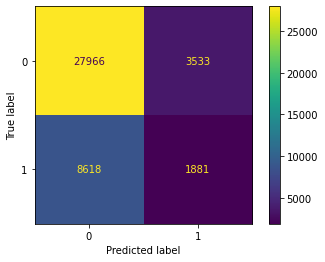

{'Accuracy': 0.7106766988904234, 'Balanced_Accuracy': 0.5334988145630017, 'Precision': 0.34743258219431106, 'Recall': 0.17915991999238023, 'F1': 0.23641048199585246}


predicted,-1.0,1.0
original,,
-1,6658,487
1,802,1579


---------Reuters Train25 Confusion Matrix---------


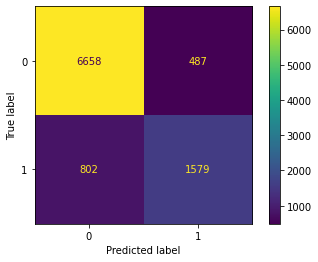

{'Accuracy': 0.8646861221918959, 'Balanced_Accuracy': 0.7975035922654535, 'Precision': 0.7642787996127783, 'Recall': 0.6631667366652667, 'F1': 0.7101416685405891}


predicted,-1.0,1.0
original,,
-1,1120,89
1,193,210


-----------BBC Train25 Confusion Matrix-----------


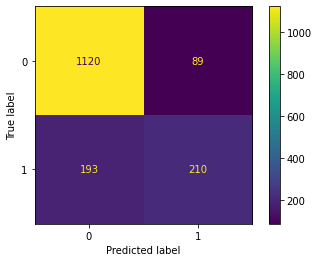

{'Accuracy': 0.825062034739454, 'Balanced_Accuracy': 0.7237386269644335, 'Precision': 0.7023411371237458, 'Recall': 0.5210918114143921, 'F1': 0.5982905982905983}


predicted,-1.0,1.0
original,,
-1,4982,23
1,1604,64


---------PressTV Train25 Confusion Matrix---------


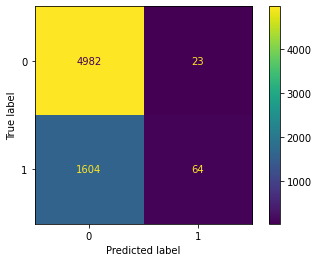

{'Accuracy': 0.7561816274539188, 'Balanced_Accuracy': 0.5168869499804751, 'Precision': 0.735632183908046, 'Recall': 0.03836930455635491, 'F1': 0.07293447293447293}


predicted,-1.0,1.0
original,,
-1,1,4854
1,0,1618


-----------CNN Test25 Confusion Matrix------------


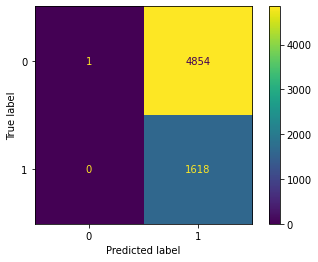

{'Accuracy': 0.2501158659045265, 'Balanced_Accuracy': 0.5001029866117405, 'Precision': 0.25, 'Recall': 1.0, 'F1': 0.4}


predicted,1.0
original,
-1,1336
1,445


---------Reuters Test25 Confusion Matrix----------


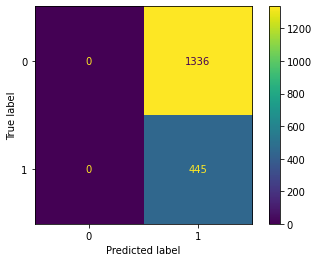

{'Accuracy': 0.24985962942167322, 'Balanced_Accuracy': 0.5, 'Precision': 0.24985962942167322, 'Recall': 1.0, 'F1': 0.3998203054806828}


predicted,1.0
original,
-1,170
1,56


-----------BBC Test25 Confusion Matrix------------


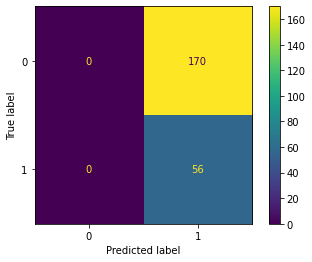

{'Accuracy': 0.24778761061946902, 'Balanced_Accuracy': 0.5, 'Precision': 0.24778761061946902, 'Recall': 1.0, 'F1': 0.3971631205673759}


predicted,-1.0,1.0
original,,
-1,863,28
1,212,84


---------PressTV Test25 Confusion Matrix----------


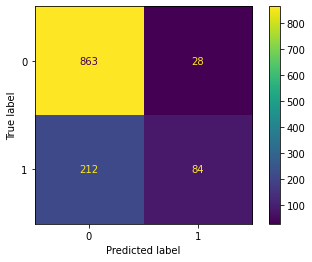

{'Accuracy': 0.797809604043808, 'Balanced_Accuracy': 0.6261792095125429, 'Precision': 0.75, 'Recall': 0.28378378378378377, 'F1': 0.4117647058823529}


predicted,-1.0,1.0
original,,
-1,39899,0
1,2095,4


-----------CNN Train5 Confusion Matrix------------


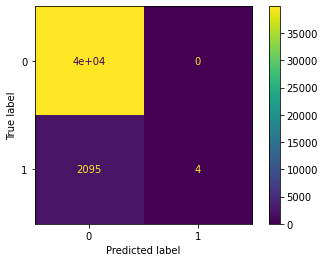

{'Accuracy': 0.9501166722224867, 'Balanced_Accuracy': 0.5009528346831824, 'Precision': 1.0, 'Recall': 0.0019056693663649356, 'F1': 0.0038040893961008085}


predicted,-1.0,1.0
original,,
-1,9049,1
1,109,367


---------Reuters Train5 Confusion Matrix----------


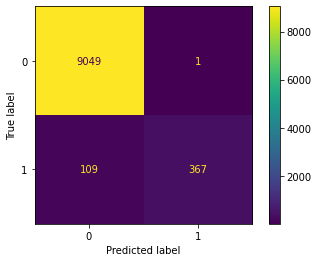

{'Accuracy': 0.9884526558891455, 'Balanced_Accuracy': 0.8854489530618878, 'Precision': 0.9972826086956522, 'Recall': 0.7710084033613446, 'F1': 0.8696682464454977}


predicted,-1.0,1.0
original,,
-1,1532,0
1,38,42


-----------BBC Train5 Confusion Matrix------------


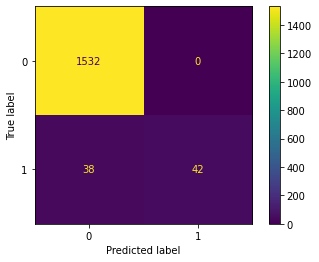

{'Accuracy': 0.9764267990074442, 'Balanced_Accuracy': 0.7625, 'Precision': 1.0, 'Recall': 0.525, 'F1': 0.6885245901639345}


predicted,-1.0,1.0
original,,
-1,6339,1
1,46,287


---------PressTV Train5 Confusion Matrix----------


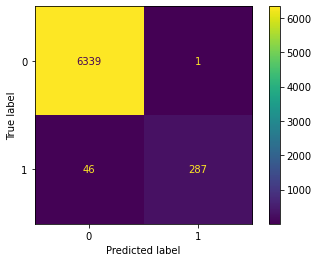

{'Accuracy': 0.9929566911434138, 'Balanced_Accuracy': 0.9308520665776187, 'Precision': 0.9965277777777778, 'Recall': 0.8618618618618619, 'F1': 0.9243156199677939}


predicted,-1.0,1.0
original,,
-1,6138,12
1,309,14


------------CNN Test5 Confusion Matrix------------


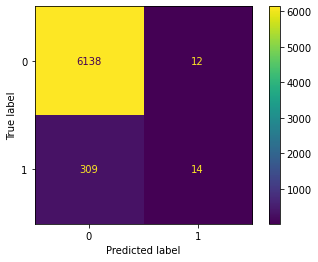

{'Accuracy': 0.9504093928626602, 'Balanced_Accuracy': 0.5206962168692895, 'Precision': 0.5384615384615384, 'Recall': 0.043343653250773995, 'F1': 0.08022922636103152}


predicted,-1.0,1.0
original,,
-1,1415,277
1,0,89


----------Reuters Test5 Confusion Matrix----------


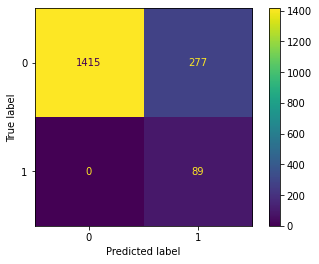

{'Accuracy': 0.8444693992139247, 'Balanced_Accuracy': 0.918144208037825, 'Precision': 0.24316939890710382, 'Recall': 1.0, 'F1': 0.3912087912087912}


predicted,-1.0,1.0
original,,
-1,174,41
1,4,7


------------BBC Test5 Confusion Matrix------------


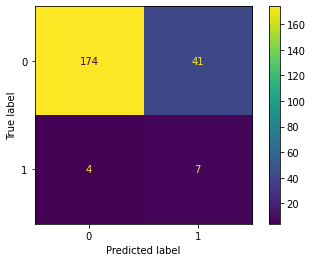

{'Accuracy': 0.8008849557522124, 'Balanced_Accuracy': 0.7228329809725158, 'Precision': 0.14583333333333334, 'Recall': 0.6363636363636364, 'F1': 0.23728813559322035}


predicted,-1.0,1.0
original,,
-1,1128,0
1,53,6


----------PressTV Test5 Confusion Matrix----------


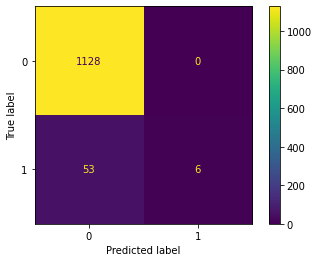

{'Accuracy': 0.9553496208930076, 'Balanced_Accuracy': 0.5508474576271186, 'Precision': 1.0, 'Recall': 0.1016949152542373, 'F1': 0.18461538461538463}


In [29]:
def calculate_metrics_for_model(res_df, nm): 
    test_accuracy = accuracy_score(res_df.original, res_df.predicted)
    test_balanced_acc = balanced_accuracy_score(res_df.original, res_df.predicted)
    test_f1 = f1_score(res_df.original, res_df.predicted)
    test_precision = precision_score(res_df.original, res_df.predicted)
    test_recall = recall_score(res_df.original, res_df.predicted)

    print((nm+" Confusion Matrix").center(50,"-"))
    cm = confusion_matrix(res_df.original, res_df.predicted)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    print({"Accuracy" : test_accuracy, "Balanced_Accuracy": test_balanced_acc, 
          "Precision": test_precision, "Recall": test_recall, "F1": test_f1})

def evaluate_mlt(X, Y, W, c, i, nm):
    
    X = X.copy()
    X.columns = range(0,X.shape[1])
    res = np.sign(X.dot(W[i]) + c[i])

    #display(res)
    df_res = pd.DataFrame(data={'original':Y,'predicted':res})
    #display(df_res.loc[df_res["original"]==1,:])
    #display(df_res.loc[df_res["original"]==-1,:])
    
    display(pd.crosstab(df_res["original"], df_res["predicted"]))
    
    calculate_metrics_for_model(df_res, nm)
    

W = pd.read_csv('train_w25.csv',header=None)
c = np.genfromtxt('train_c25.csv',delimiter=',')
    
evaluate_mlt(X_cnnTrain25, Y_cnnTrain25, W, c, 0, 'CNN Train25')
evaluate_mlt(X_reuTrain25, Y_reuTrain25, W, c, 1, 'Reuters Train25')
evaluate_mlt(X_bbcTrain25, Y_bbcTrain25, W, c, 2, 'BBC Train25')
evaluate_mlt(X_preTrain25, Y_preTrain25, W, c, 3, 'PressTV Train25')

evaluate_mlt(X_cnnTest25, Y_cnnTest25, W, c, 0, 'CNN Test25')
evaluate_mlt(X_reuTest25, Y_reuTest25, W, c, 1, 'Reuters Test25')
evaluate_mlt(X_bbcTest25, Y_bbcTest25, W, c, 2, 'BBC Test25')
evaluate_mlt(X_preTest25, Y_preTest25, W, c, 3, 'PressTV Test25')

W = pd.read_csv('train_w5.csv',header=None)
c = np.genfromtxt('train_c5.csv',delimiter=',')

evaluate_mlt(X_cnnTrain5, Y_cnnTrain5, W, c, 0, 'CNN Train5')
evaluate_mlt(X_reuTrain5, Y_reuTrain5, W, c, 1, 'Reuters Train5')
evaluate_mlt(X_bbcTrain5, Y_bbcTrain5, W, c, 2, 'BBC Train5')
evaluate_mlt(X_preTrain5, Y_preTrain5, W, c, 3, 'PressTV Train5')

evaluate_mlt(X_cnnTest5, Y_cnnTest5, W, c, 0, 'CNN Test5')
evaluate_mlt(X_reuTest5, Y_reuTest5, W, c, 1, 'Reuters Test5')
evaluate_mlt(X_bbcTest5, Y_bbcTest5, W, c, 2, 'BBC Test5')
evaluate_mlt(X_preTest5, Y_preTest5, W, c, 3, 'PressTV Test5')

# SVM Full model (STL-All)

Within this chapter the single task learning model, **STL-All** (SVM classifier trained on all the data from all channels) is implemented based on the Paper Analyzing and Predicting News Popularity in an Instant Messaging Service. It is checked whether or not the implementation and the results reported in the paper are reproducible and what information might be missing or wrong.

Note that preprocessing needs to be slightly adapted to include channel name and standardize on a per-channel basis. Resulting datasets are therefore comparable to STL and MALSAR.

In [30]:
def add_channel(df, channel):
    df['channel']=channel
    return df


def create_df_for_bson(path, channel):
  with open (path, 'rb') as f:
    data = bson.decode_all(f.read())

  df = pd.DataFrame(data)
  df = handle_NAS(df)
  df = extract_features(df)
  df = cut_date_range(df)
  df = drop_unused_features(df)
  df = add_channel(df, channel)
  return df


# keep needed features, more flexible as different datasets contain different features
def drop_unused_features(df):
  return df.drop(df.columns.difference(['age', 'date', 'year', 'month', 'day', 'weekday', 
                          'hour', 'minViews', 'maxViews', 'meanViews', 'stdViews',
                          'hasMedia', 'mediaType', 'hasLink', 'mentions', 'hashtags', 'views']),axis=1)

 
reutersWorld = create_df_for_bson('./TelegramNews/mongo/telegram/ReutersWorld.bson', 'reutersWorld')
cnnBrk = create_df_for_bson('./TelegramNews/mongo/telegram/CNNBrk.bson', 'cnnBrk')
pressTV = create_df_for_bson('./TelegramNews/mongo/telegram/presstv.bson', 'pressTV')
bbcBreaking = create_df_for_bson('./TelegramNews/mongo/telegram/bbcbreaking.bson', 'bbc')
bbcPersian = create_df_for_bson('./TelegramNews/mongo/telegram/bbcpersian.bson', 'bbc')
washingtonPost = create_df_for_bson('./TelegramNews/mongo/telegram/washingtonpost.bson', 'washingtonPost')

In the paper it is not clearly stated which datasets are included in training SVM all. In the repository we found more datasets than the ones listed in the table comparing the different models. Hence we simply assumed that for training SVM all, all available datasets (except the Guardian as it doesn't contain data) are used and only the ones listed in the mentioned table are used for prediction.

Also they predicted BBC, however two datasets called bbcBreaking and bbcPersian do exist. It is not clear if BBC simply combines these two, or if only one of them is chosen as BBC.

In [31]:
dfs = [reutersWorld, cnnBrk, bbcBreaking, bbcPersian, pressTV, washingtonPost]
all = pd.concat(dfs)

We assumed that the train and test split is done first according to *Therefore, we first found the thresholds that satisfy these percentages for training and test sets and assigned a binary label to each post*. Also, if the split is done after assigning the popularity, in e.g. the cnn test set no popular posts can be found and the prediction would have an accuracy of 1.0, which is not the case in the paper.

In [32]:
def create_train_test_split(df):
  # the first six months (March - September) of the data is selected for training and the last month (October)
  # is selected for testing.
   # March 8, 2017 to September 7, 2017.
  train_start = "2017-03-08"
  train_end = "2017-09-07"
  mask = (df.date > train_start) & (df.date <= train_end)

  df = df.drop(labels=['date'],axis=1)
  df.mediaType = df.mediaType.astype('category').cat.codes

  training = df.loc[mask]
  test = df.loc[-mask]

  return training, test

In [33]:
allTrain, allTest = create_train_test_split(all)

print(f"Size of Training set: {len(allTrain.index)}")
print(f"Size of Test set: {len(allTest.index)}")
print(f"Percentage of train split: {round(100 * len(allTrain.index) / len(all.index),2)}%")

Size of Training set: 64916
Size of Test set: 11056
Percentage of train split: 85.45%


It is not clearly stated in the paper how the threshold which is used to state whether a post is popular or not is defined. In this case it is assumed, that the more views a post has, the more popular it is

In [34]:
# popular = 1
# not popular = 0

def assign_popularity (df, percent):
  df.sort_values(by=['views'], inplace=True, ascending=False)
  
  quantile = (100-percent)/100
  threshold = df.loc[:,'views'].quantile(quantile)
  is_popular = df.loc[:,'views'] > threshold

  df.loc[is_popular,'Popular']=1
  df.loc[~is_popular, 'Popular']=0

  return df

allTrain_5 = assign_popularity(allTrain, 5)
allTest_5 = assign_popularity(allTest, 5)

allTrain_25 = assign_popularity(allTrain, 25)
allTest_25 = assign_popularity(allTest, 25)

In [35]:
print(allTrain_5)

           views         age  year  month  day  weekday  hour  minViews  \
2716   1908500.0  1501109574  2017      7   26        2    22   78130.0   
4817   1482198.0  1495247786  2017      5   20        5     2   78130.0   
5007   1475636.0  1494845222  2017      5   15        0    10   78130.0   
4550   1364851.0  1495645444  2017      5   24        2    17   78130.0   
5729   1233545.0  1492715698  2017      4   20        3    19   78130.0   
...          ...         ...   ...    ...  ...      ...   ...       ...   
52145        6.0  1489419870  2017      3   13        0    15       5.0   
52167        6.0  1489418859  2017      3   13        0    15       5.0   
52168        5.0  1489418858  2017      3   13        0    15       5.0   
52169        5.0  1489418856  2017      3   13        0    15       5.0   
52170        5.0  1489418855  2017      3   13        0    15       5.0   

        maxViews      meanViews       stdViews  hasMedia  mediaType  hasLink  \
2716   2904081.0  4

In [36]:
# Apply Min-Max scaling fitted on the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#training
scaled_training_5 = pd.DataFrame(scaler.fit_transform(allTrain_5.drop('channel', axis=1)), columns=allTrain_5.drop('channel', axis=1).columns)
scaled_training_25 = pd.DataFrame(scaler.fit_transform(allTrain_25.drop('channel', axis=1)), columns=allTrain_25.drop('channel', axis=1).columns)
#test
scaled_test_5 = pd.DataFrame(scaler.transform(allTest_5.drop('channel', axis=1)), columns=allTest_5.drop('channel', axis=1).columns)
scaled_test_25 = pd.DataFrame(scaler.transform(allTest_25.drop('channel', axis=1)), columns=allTest_25.drop('channel', axis=1).columns)


def scale_partial(df, channel):
  is_channel = df.loc[:, 'channel']==channel
  channel_df = df.loc[is_channel]
  return pd.DataFrame(scaler.transform(channel_df.drop('channel', axis=1)), 
                      columns=channel_df.drop('channel', axis=1).columns)

cnn_scaled_test_5 = scale_partial(allTest_5, 'cnnBrk')
reuters_scaled_test_5 = scale_partial(allTest_5, 'reutersWorld')
press_scaled_test_5 = scale_partial(allTest_5, 'pressTV')
bbc_scaled_test_5 = scale_partial(allTest_5, 'bbc')

cnn_scaled_test_25 = scale_partial(allTest_25, 'cnnBrk')
reuters_scaled_test_25 = scale_partial(allTest_25, 'reutersWorld')
press_scaled_test_25 = scale_partial(allTest_25, 'pressTV')
bbc_scaled_test_25 = scale_partial(allTest_25, 'bbc')

print(scaled_training_5)

              views       age  year     month       day   weekday      hour  \
0      1.000000e+00  0.770360   0.0  0.666667  0.833333  0.333333  0.956522   
1      7.766292e-01  0.399538   0.0  0.333333  0.633333  0.833333  0.086957   
2      7.731909e-01  0.374071   0.0  0.333333  0.466667  0.000000  0.434783   
3      7.151426e-01  0.424694   0.0  0.333333  0.766667  0.333333  0.739130   
4      6.463418e-01  0.239356   0.0  0.166667  0.633333  0.500000  0.826087   
...             ...       ...   ...       ...       ...       ...       ...   
64911  5.239731e-07  0.030859   0.0  0.000000  0.400000  0.000000  0.652174   
64912  5.239731e-07  0.030795   0.0  0.000000  0.400000  0.000000  0.652174   
64913  0.000000e+00  0.030795   0.0  0.000000  0.400000  0.000000  0.652174   
64914  0.000000e+00  0.030795   0.0  0.000000  0.400000  0.000000  0.652174   
64915  0.000000e+00  0.030794   0.0  0.000000  0.400000  0.000000  0.652174   

       minViews  maxViews  meanViews  stdViews  has

## SVM

Aim is to predict top 5% and top 25% popular news for each agency. Therefore train svm classifier on all channels and predict popular news for only one **channel**

In [37]:
def calculate_weights(train_df):
  n = len(train_df.index)
  labels = train_df.Popular
  popular = len(labels[labels == 1])
  not_popular = n - popular

  denominator = sum((1 / (popular if labels[k] == 1 else not_popular)) for k in range(1,n))
  bigLambda = map(lambda i: (1 / (popular if labels[i] == 1 else not_popular)) * denominator, range(0, n))
  return pd.Series(bigLambda)

weights_5 = calculate_weights(scaled_training_5)
weights_25 = calculate_weights(scaled_training_25)

### Top 5%
Interestingly using GridSearch including the weights as stated in the paper, the results are way more different than simply applying svc (using default settings). If adding the weights to the simple svc implementation, the results turn out to be exactly the same as when using the gridSearch implementation.

In [38]:
y5 = scaled_training_5['Popular']
x5 = scaled_training_5.drop('Popular', axis=1)

param_grid = {'C' : np.logspace(-3, 2, 6)}
weight_array = weights_5.unique()
weight_dict = {0 : weight_array[0], 1 : weight_array[1]}

In [39]:
clf = svm.SVC()
clf.fit(x5, y5)

SVC()

In [117]:
svc_classifier_grid = GridSearchCV(svm.SVC(), param_grid=param_grid)
clf_grid = svc_classifier_grid.fit(x5,y5)

KeyboardInterrupt: 

In [ ]:
svc_classifier_grid = GridSearchCV(svm.SVC(class_weight=weight_dict), param_grid=param_grid, n_jobs=8)
clf_grid_weighted = svc_classifier_grid.fit(x5,y5)

In [ ]:
svc_classifier_grid = GridSearchCV(svm.LinearSVC(), cv=5, param_grid=param_grid, n_jobs=8)
clf_grid_linear = svc_classifier_grid.fit(x5,y5)

In [ ]:
svc_classifier_grid = GridSearchCV(svm.LinearSVC(class_weight=weight_dict), param_grid=param_grid, cv=5, n_jobs=8)
clf_grid_weighted_linear = svc_classifier_grid.fit(x5,y5)

#### Prediction + Evaluation of Top5% models

In [ ]:
def model_metrics(true, predicted):
  acc = accuracy_score(true, predicted)
  ba = balanced_accuracy_score(true, predicted)
  prec = precision_score(true, predicted)
  recall = recall_score(true, predicted)
  f1 = f1_score(true, predicted)

  print('Accuracy: ', acc)
  print('Balanced Accuracy: ', ba)
  print('Precision: ', prec)
  print('Recall: ', recall)
  print('F1: ', f1)

  return confusion_matrix(true, predicted)

Prediction for CNN

In [ ]:
y5_cnn_test = cnn_scaled_test_5['Popular']
x5_cnn_test = cnn_scaled_test_5.drop('Popular', axis=1)

cnn_default = clf.predict(x5_cnn_test)
print('clf - default settings')
print(model_metrics(y5_cnn_test, cnn_default))

In [ ]:
cnn_grid = clf_grid.predict(x5_cnn_test)
print('grid - default settings')
print(model_metrics(y5_cnn_test, cnn_grid))

In [ ]:
cnn_grid_weighted = clf_grid_weighted.predict(x5_cnn_test)
print('grid - weighted')
print(model_metrics(y5_cnn_test, cnn_grid_weighted))

In [ ]:
cnn_grid_linear = clf_grid_linear.predict(x5_cnn_test)
print('grid - linear')
print(model_metrics(y5_cnn_test, cnn_grid_linear))

In [ ]:
cnn_grid_linear_weighted = clf_grid_weighted_linear.predict(x5_cnn_test)
print('grid - linear + weighted')
print(model_metrics(y5_cnn_test, cnn_grid_linear_weighted))

Prediction for BBC

In [ ]:
y5_bbc_test = bbc_scaled_test_5['Popular']
x5_bbc_test = bbc_scaled_test_5.drop('Popular', axis=1)

bbc_default = clf.predict(x5_bbc_test)
print('clf - default settings')
print(model_metrics(y5_bbc_test, bbc_default))

In [ ]:
bbc_grid = clf_grid.predict(x5_bbc_test)
print('grid - default settings')
print(model_metrics(y5_bbc_test, bbc_grid))

In [ ]:
bbc_grid_weighted = clf_grid_weighted.predict(x5_bbc_test)
print('grid - weighted')
print(model_metrics(y5_bbc_test, bbc_grid_weighted))

In [ ]:
bbc_grid_linear_weighted = clf_grid_weighted_linear.predict(x5_bbc_test)
print('grid - linear + weighted')
print(model_metrics(y5_bbc_test, bbc_grid_linear_weighted))

Prediction for Reuters

In [ ]:
y5_reuters_test = reuters_scaled_test_5['Popular']
x5_reuters_test = reuters_scaled_test_5.drop('Popular', axis=1)

reuters_default = clf.predict(x5_reuters_test)
print('clf - default settings')
print(model_metrics(y5_reuters_test, reuters_default))

In [ ]:
reuters_grid = clf_grid.predict(x5_reuters_test)
print('grid - default settings')
print(model_metrics(y5_reuters_test, reuters_grid))

In [ ]:
reuters_grid_weighted = clf_grid_weighted.predict(x5_reuters_test)
print('grid - weighted')
print(model_metrics(y5_reuters_test, reuters_grid_weighted))

In [ ]:
reuters_grid_linear_weighted = clf_grid_weighted_linear.predict(x5_reuters_test)
print('grid - linear + weighted')
print(model_metrics(y5_reuters_test, reuters_grid_linear_weighted))

Prediction for PressTV

In [ ]:
y5_press_test = press_scaled_test_5['Popular']
x5_press_test = press_scaled_test_5.drop('Popular', axis=1)

press_default = clf.predict(x5_press_test)
print('clf - default settings')
print(model_metrics(y5_press_test, press_default))

In [ ]:
press_grid = clf_grid.predict(x5_press_test)
print('grid - default settings')
print(model_metrics(y5_press_test, press_grid))

In [ ]:
press_grid_weighted = clf_grid_weighted.predict(x5_press_test)
print('grid - weighted')
print(model_metrics(y5_press_test, press_grid_weighted))

In [ ]:
press_grid_linear_weighted = clf_grid_weighted_linear.predict(x5_press_test)
print('grid - linear + weighted')
print(model_metrics(y5_press_test, press_grid_linear_weighted))

## Top 25%

In [ ]:
y25 = scaled_training_25['Popular']
x25 = scaled_training_25.drop('Popular', axis=1)

param_grid = {'C' : np.logspace(-3, 2, 6)}
weight_array_25 = weights_25.unique()
weight_dict_25 = {0 : weight_array_25[0], 1 : weight_array_25[1]}

In [ ]:
# default SVM
clf_25 = svm.SVC()
clf_25.fit(x25, y25)

In [ ]:
# default kernel (rbf), no weights
svc_classifier_grid_25 = GridSearchCV(svm.SVC(), param_grid=param_grid)
clf_grid_25 = svc_classifier_grid_25.fit(x25,y25)

In [ ]:
# default kernel (rbf), weights
svc_classifier_grid_25 = GridSearchCV(svm.SVC(class_weight=weight_dict_25), param_grid=param_grid, n_jobs=8)
clf_grid_weighted_25 = svc_classifier_grid_25.fit(x25,y25)

In [ ]:
# linear kernel, no weights
svc_classifier_grid_25 = GridSearchCV(svm.LinearSVC(), cv=5, param_grid=param_grid, n_jobs=8)
clf_grid_linear_25 = svc_classifier_grid_25.fit(x25,y25)

In [ ]:
# linear kernel, weights
svc_classifier_grid_25 = GridSearchCV(svm.LinearSVC(class_weight=weight_dict_25), param_grid=param_grid, cv=5, n_jobs=8)
clf_grid_weighted_linear_25 = svc_classifier_grid_25.fit(x25,y25)

#### Prediction + Evaluation for Top 25% models

Prediction for CNN

In [ ]:
y25_cnn_test = cnn_scaled_test_25['Popular']
x25_cnn_test = cnn_scaled_test_25.drop('Popular', axis=1)

cnn_default_25 = clf_25.predict(x25_cnn_test)
print('clf - default settings')
print(model_metrics(y25_cnn_test, cnn_default_25))

In [ ]:
cnn_grid_25 = clf_grid_25.predict(x25_cnn_test)
print('grid - default settings')
print(model_metrics(y25_cnn_test, cnn_grid_25))

In [ ]:
cnn_grid_weighted_25 = clf_grid_weighted_25.predict(x25_cnn_test)
print('grid - weighted')
print(model_metrics(y25_cnn_test, cnn_grid_weighted_25))

In [ ]:
cnn_grid_linear_25 = clf_grid_linear_25.predict(x25_cnn_test)
print('grid - linear')
print(model_metrics(y25_cnn_test, cnn_grid_linear_25))

In [ ]:
cnn_grid_linear_weighted_25 = clf_grid_weighted_linear_25.predict(x25_cnn_test)
print('grid - linear + weighted')
print(model_metrics(y25_cnn_test, cnn_grid_linear_weighted_25))

Prediction for BBC

In [ ]:
y25_bbc_test = bbc_scaled_test_25['Popular']
x25_bbc_test = bbc_scaled_test_25.drop('Popular', axis=1)

bbc_default_25 = clf_25.predict(x25_bbc_test)
print('clf - default settings')
print(model_metrics(y25_bbc_test, bbc_default_25))

In [ ]:
bbc_grid_25 = clf_grid_25.predict(x25_bbc_test)
print('grid - default settings')
print(model_metrics(y25_bbc_test, bbc_grid_25))

In [ ]:
bbc_grid_weighted_25 = clf_grid_weighted_25.predict(x25_bbc_test)
print('grid - weighted')
print(model_metrics(y25_bbc_test, bbc_grid_weighted_25))

In [ ]:
bbc_grid_linear_weighted_25 = clf_grid_weighted_linear_25.predict(x25_bbc_test)
print('grid - linear + weighted')
print(model_metrics(y25_bbc_test, bbc_grid_linear_weighted_25))

Prediction for Reuters

In [ ]:
y25_reuters_test = reuters_scaled_test_25['Popular']
x25_reuters_test = reuters_scaled_test_25.drop('Popular', axis=1)

reuters_default_25 = clf_25.predict(x25_reuters_test)
print('clf - default settings')
print(model_metrics(y25_reuters_test, reuters_default_25))

In [ ]:
reuters_grid_25 = clf_grid_25.predict(x25_reuters_test)
print('grid - default settings')
print(model_metrics(y25_reuters_test, reuters_grid_25))

In [ ]:
reuters_grid_weighted_25 = clf_grid_weighted_25.predict(x25_reuters_test)
print('grid - weighted')
print(model_metrics(y25_reuters_test, reuters_grid_weighted_25))

In [ ]:
reuters_grid_linear_weighted_25 = clf_grid_weighted_linear_25.predict(x25_reuters_test)
print('grid - linear + weighted')
print(model_metrics(y25_reuters_test, reuters_grid_linear_weighted_25))

Prediction for PressTV

In [ ]:
y25_press_test = press_scaled_test_25['Popular']
x25_press_test = press_scaled_test_25.drop('Popular', axis=1)

press_default_25 = clf_25.predict(x25_press_test)
print('clf - default settings')
print(model_metrics(y25_press_test, press_default_25))

In [ ]:
press_grid_25 = clf_grid_25.predict(x25_press_test)
print('grid - default settings')
print(model_metrics(y25_press_test, press_grid_25))

In [ ]:
press_grid_weighted_25 = clf_grid_weighted_25.predict(x25_press_test)
print('grid - weighted')
print(model_metrics(y25_press_test, press_grid_weighted_25))

In [ ]:
press_grid_linear_weighted_25 = clf_grid_weighted_linear_25.predict(x25_press_test)
print('grid - linear + weighted')
print(model_metrics(y25_press_test, press_grid_linear_weighted_25))